In [1]:
import pandas as pd
import os
import regex as re
import copy
import folium
from branca.colormap import LinearColormap




In [3]:
# Read the crop.csv file into a DataFrame
colab = True

if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    data = pd.read_csv('/content/drive/MyDrive/CS418/Data_Bandits_CS418/data/crop_data/corn.csv')
else:
    data = pd.read_csv('../data/crop_data/corn.csv')

Mounted at /content/drive


In [6]:
print(data.head())

# Create a new empty DataFrame
cleaned_df = pd.DataFrame()


   YEAR    LOCATION STATE ANSI ASD CODE COUNTY ANSI REFERENCE PERIOD  \
0  2000     ALABAMA         01                                  YEAR   
1  2000     ARIZONA         04                                  YEAR   
2  2000    ARKANSAS         05                                  YEAR   
3  2000  CALIFORNIA         06                                  YEAR   
4  2000    COLORADO         08                                  YEAR   

  COMMODITY AREA HARVESTED in ACRES PRODUCTION in BU YIELD in BU / ACRE  \
0      CORN                                                               
1      CORN                                                               
2      CORN                                                               
3      CORN                                                               
4      CORN                                                               

  AREA PLANTED in ACRES PRODUCTION in $ PRODUCTION in TONS  \
0               230,000                               

In [7]:
cleaned_df = copy.deepcopy(data)


cleaned_df["PriceIsNan"] = data["PRICE RECEIVED in $ / BU"].apply(lambda x: not bool(re.match(r'^[0-9]', str(x))))
cleaned_df["AreaisNan"] = data["AREA PLANTED in ACRES"].apply(lambda x: not bool(re.match(r'^[0-9]', str(x))))

# Filter rows where "AREA PLANTED in ACRES" is greater than 100,000
# First remove commas from the values and convert to numeric
cleaned_df = data[cleaned_df['AreaisNan'] == False]
cleaned_df["AREA PLANTED in ACRES"] = cleaned_df["AREA PLANTED in ACRES"].str.replace(',', '').astype(int)
cleaned_df = cleaned_df[cleaned_df["AREA PLANTED in ACRES"] > 3000000]

<ipython-input-7-b528bd78572e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df["AREA PLANTED in ACRES"] = cleaned_df["AREA PLANTED in ACRES"].str.replace(',', '').astype(int)


In [8]:
cleaned_df.head()

,YEAR,LOCATION,STATE ANSI,ASD CODE,COUNTY ANSI,REFERENCE PERIOD,COMMODITY,AREA HARVESTED in ACRES,PRODUCTION in BU,YIELD in BU / ACRE,AREA PLANTED in ACRES,PRODUCTION in $,PRODUCTION in TONS,YIELD in TONS / ACRE,PRICE RECEIVED in $ / BU
10,2000,ILLINOIS,17,,,YEAR,CORN,,,,11200000,,,,
11,2000,INDIANA,18,,,YEAR,CORN,,,,5700000,,,,
12,2000,IOWA,19,,,YEAR,CORN,,,,12300000,,,,
13,2000,KANSAS,20,,,YEAR,CORN,,,,3450000,,,,
20,2000,MINNESOTA,27,,,YEAR,CORN,,,,7200000,,,,


In [9]:
# Create a clean copy of the data
cleaned_df = copy.deepcopy(data)

# Filter for corn grain only
cleaned_df = cleaned_df[cleaned_df['COMMODITY'] == "CORN, GRAIN"]

# Create separate dataframes for year and marketing year rows
year_df = cleaned_df[cleaned_df['REFERENCE PERIOD'] == 'YEAR'].copy()
marketing_year_df = cleaned_df[cleaned_df['REFERENCE PERIOD'] == 'MARKETING YEAR'].copy()

# Create a mapping of (location, year) to price
price_mapping = marketing_year_df.set_index(['LOCATION', 'YEAR'])['PRICE RECEIVED in $ / BU']

# Map the prices to the year rows using location and year as keys
year_df['PRICE RECEIVED in $ / BU'] = year_df.apply(
    lambda row: price_mapping.get((row['LOCATION'], row['YEAR']), None),
    axis=1
)

# This will be our final dataframe
cleaned_df = year_df

# Drop unnecessary columns
cleaned_df = cleaned_df.drop(["PRODUCTION in TONS", "COMMODITY", "ASD CODE", "COUNTY ANSI", "AREA PLANTED in ACRES", "YIELD in TONS / ACRE", "STATE ANSI"], axis=1)

In [10]:
cleaned_df.head()

,YEAR,LOCATION,REFERENCE PERIOD,AREA HARVESTED in ACRES,PRODUCTION in BU,YIELD in BU / ACRE,PRODUCTION in $,PRICE RECEIVED in $ / BU
1210,2000,ALABAMA,YEAR,"165,000","10,725,000",65,"23,166,000",2.16
1212,2000,ARIZONA,YEAR,"33,000","6,468,000",196,"17,981,000",2.78
1214,2000,ARKANSAS,YEAR,"175,000","22,750,000",130,"39,813,000",1.75
1216,2000,CALIFORNIA,YEAR,"205,000","34,850,000",170,"85,034,000",2.44
1218,2000,COLORADO,YEAR,"1,150,000","144,900,000",126,"301,392,000",2.08


In [11]:
# Convert both columns to numeric
cleaned_df['PRODUCTION in BU'] = pd.to_numeric(
    cleaned_df['PRODUCTION in BU'].astype(str).str.replace(',', ''),
    errors='coerce'
)

cleaned_df['PRICE RECEIVED in $ / BU'] = pd.to_numeric(
    cleaned_df['PRICE RECEIVED in $ / BU'],
    errors='coerce'
)

# Group by location and calculate mean for numeric columns
location_averages = cleaned_df.groupby('LOCATION').agg({
    'PRODUCTION in BU': 'mean',
    'PRICE RECEIVED in $ / BU': 'mean'
}).round(2)

# Sort by area harvested to see largest producers first
location_averages = location_averages.sort_values('PRODUCTION in BU', ascending=False)

# Display the results
print("Number of locations:", len(location_averages))
location_averages

Number of locations: 42


,PRODUCTION in BU,PRICE RECEIVED in $ / BU
LOCATION,,
IOWA,2.275598e+09,3.88
ILLINOIS,2.004372e+09,3.90
NEBRASKA,1.492326e+09,3.88
MINNESOTA,1.254270e+09,3.75
INDIANA,9.030940e+08,4.00
SOUTH DAKOTA,6.224828e+08,3.68
KANSAS,5.421356e+08,3.92
OHIO,5.188112e+08,3.98
WISCONSIN,4.597904e+08,3.79


In [12]:
# Filter for locations with >= 1 million acres harvested
major_producers = location_averages[location_averages['PRODUCTION in BU'] >= 100_000_000]

# Display the results
print("Number of major producing locations:", len(major_producers))
major_producers

Number of major producing locations: 17


,PRODUCTION in BU,PRICE RECEIVED in $ / BU
LOCATION,,
IOWA,2.275598e+09,3.88
ILLINOIS,2.004372e+09,3.90
NEBRASKA,1.492326e+09,3.88
MINNESOTA,1.254270e+09,3.75
INDIANA,9.030940e+08,4.00
SOUTH DAKOTA,6.224828e+08,3.68
KANSAS,5.421356e+08,3.92
OHIO,5.188112e+08,3.98
WISCONSIN,4.597904e+08,3.79


In [14]:
state_data = pd.read_csv('/content/drive/MyDrive/CS418/Data_Bandits_CS418/data/crop_data/US_GeoCode.csv')

# Make all the state names uppercase so that it matches the corn data
state_data['Name'] = state_data['Name'].str.upper()

# Merge the state longitude and latitude with the corn data
merged_data = pd.merge(major_producers, state_data, left_on='LOCATION', right_on='Name')

print(merged_data.head())


   PRODUCTION in BU  PRICE RECEIVED in $ / BU state&teritory   latitude  \
0      2.275598e+09                      3.88             IA  41.878003   
1      2.004372e+09                      3.90             IL  40.633125   
2      1.492326e+09                      3.88             NE  41.492537   
3      1.254270e+09                      3.75             MN  46.729553   
4      9.030940e+08                      4.00             IN  40.551217   

   longitude       Name  
0 -93.097702       IOWA  
1 -89.398528   ILLINOIS  
2 -99.901813   NEBRASKA  
3 -94.685900  MINNESOTA  
4 -85.602364    INDIANA  


In [15]:
# Create a folium map centered in the US
m = folium.Map(location=[39.8283, -98.5795], zoom_start=4, tiles="cartodb positron")
scaling_factor = 60000000

# Color scale used to show the production of corn
max_production = merged_data['PRODUCTION in BU'].astype(float).max()
colormap = LinearColormap(colors=['lightyellow', 'orange', 'darkorange', 'brown'],
                          vmin=0, vmax=max_production, caption="Corn Production in Bushels")

# Title HTML to add the title to the map
title_html = '''
    <h3 align="center" style="font-size:16px"><b>Corn Production Visualization by State</b></h3>
'''
m.get_root().html.add_child(folium.Element(title_html))

# Legend HTML used to add the legend to the map
legend_html = '''
     <div style="position: fixed;
                 bottom: 50px; left: 50px; width: 200px; height: 100px;
                 background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
                 padding: 10px;">
     <b>Legend</b><br>
     <i style="background:brown; width:10px; height:10px; float:left; margin-right:5px; opacity:0.7;"></i> High Production<br>
     <i style="background:lightyellow; width:10px; height:10px; float:left; margin-right:5px; opacity:0.7;"></i> Low Production<br>
     <i style="background:white; width:10px; height:10px; float:left; margin-right:5px; border:1px solid black;"></i> No Data
     </div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Add circle markers for each state
for _, row in merged_data.iterrows():
    if pd.notnull(row['latitude']) and pd.notnull(row['longitude']):
        radius = float(row['PRODUCTION in BU']) / scaling_factor
        color = colormap(float(row['PRODUCTION in BU']))  # Get color from colormap based on production

        folium.CircleMarker(
            location=(row['latitude'], row['longitude']),
            radius=radius,
            color="black",
            fill=True,
            fill_color=color,  # Fill with gradient color based on production
            fill_opacity=0.6,
            tooltip=f"{row['Name']} - Production: {row['PRODUCTION in BU']} BU"  # Tooltip for hover
        ).add_to(m)


# Add color map legend to map
colormap.add_to(m)

m

Mean Squared Error: 0.0360
R² Score: 0.3641

Quadratic equation (x in millions of bushels):
y = 0.00000042x² + -0.00109117x + 4.3467


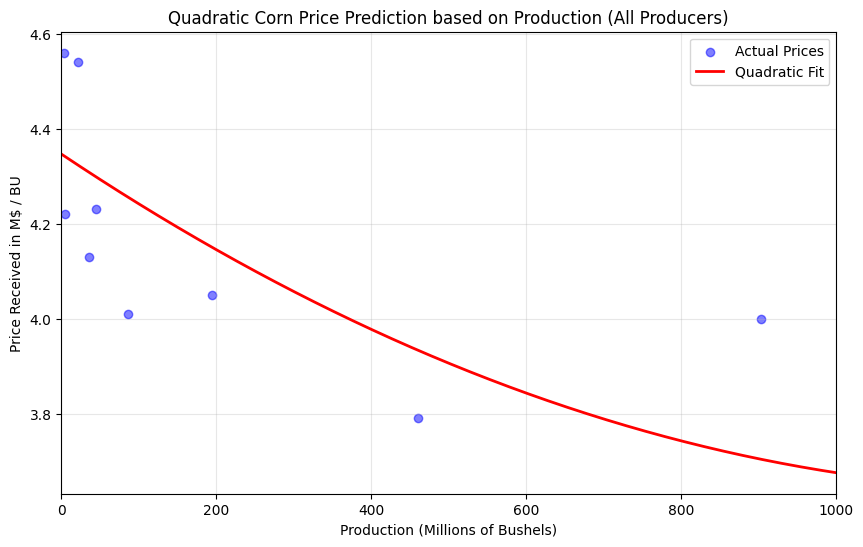

In [31]:
# Import required libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from scipy.optimize import curve_fit

# Prepare the data from location_averages (all producers)
clean_data = location_averages.dropna()

# Scale down X values to millions
X = clean_data['PRODUCTION in BU'].values / 1_000_000  # Convert to millions of bushels
y = clean_data['PRICE RECEIVED in $ / BU'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define quadratic function
def quadratic(x, a, b, c):
    return a * x**2 + b * x + c

# Fit using curve_fit with multiple initial guesses
best_fit = None
best_score = float('-inf')
initial_guesses = [
    [0.001, -0.1, 5],
    [-0.001, 0.1, 3],
    [0.0001, -0.01, 4],
    [-0.0001, 0.01, 4]
]

for guess in initial_guesses:
    try:
        popt, _ = curve_fit(quadratic, X_train, y_train, p0=guess)
        y_pred = quadratic(X_test, *popt)
        score = r2_score(y_test, y_pred)

        if score > best_score:
            best_score = score
            best_fit = popt
    except:
        continue

a, b, c = best_fit

# Make predictions
y_pred = quadratic(X_test, a, b, c)

# Print metrics
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred):.4f}')
print(f'R² Score: {r2_score(y_test, y_pred):.4f}')
print(f'\nQuadratic equation (x in millions of bushels):')
print(f'y = {a:.8f}x² + {b:.8f}x + {c:.4f}')

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual Prices', alpha=0.5)

# Create smooth curve for plotting (cropped at 1000)
X_smooth = np.linspace(0, 1000, 200)
y_smooth = quadratic(X_smooth, a, b, c)

plt.plot(X_smooth, y_smooth, color='red', label='Quadratic Fit', linewidth=2)
plt.xlabel('Production (Millions of Bushels)')
plt.ylabel('Price Received in M$ / BU')
plt.title('Quadratic Corn Price Prediction based on Production (All Producers)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1000)  # Set x-axis limits
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mean Squared Error: 0.0344
R² Score: 0.3929
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


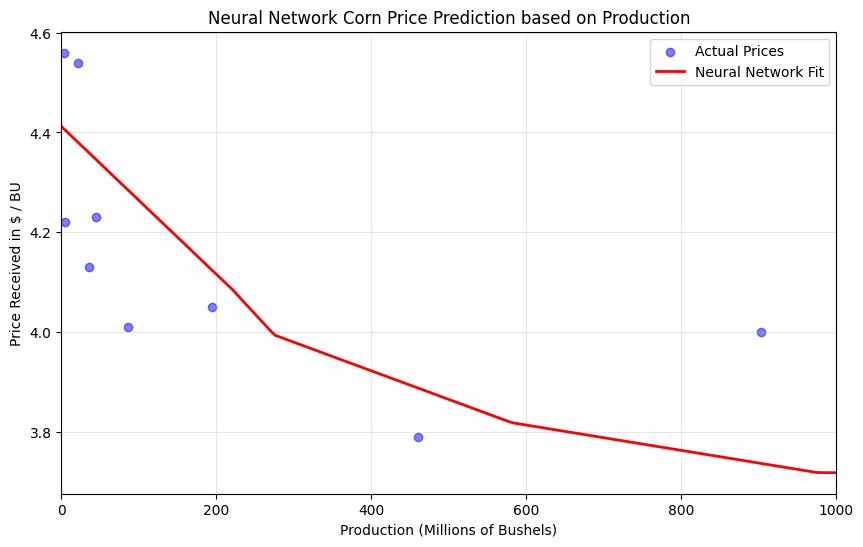

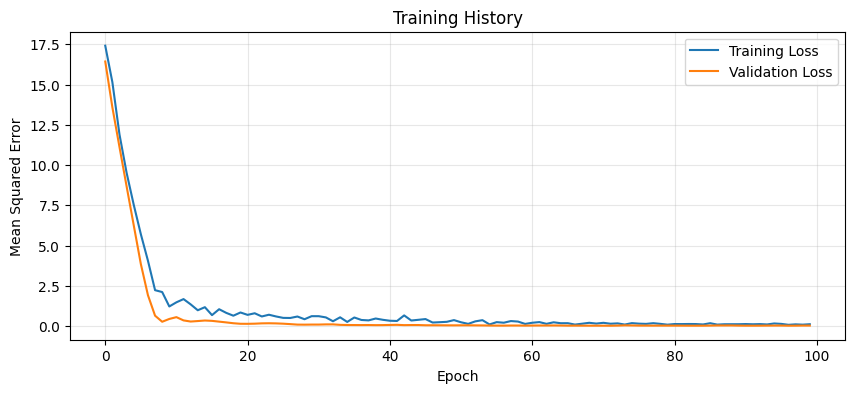

In [35]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Prepare the data from location_averages (all producers)
clean_data = location_averages.dropna()

# Scale down X values to millions
X = clean_data['PRODUCTION in BU'].values / 1_000_000  # Convert to millions of bushels
y = clean_data['PRICE RECEIVED in $ / BU'].values

# Reshape X for the neural network
X = X.reshape(-1, 1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Create a simple neural network
model = Sequential([
    Dense(8, activation='relu', input_shape=(1,)),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# Train the model
history = model.fit(X_train_scaled, y_train,
                   epochs=100,
                   batch_size=8,
                   validation_split=0.2,
                   verbose=0)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Print metrics
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred):.4f}')
print(f'R² Score: {r2_score(y_test, y_pred):.4f}')

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual Prices', alpha=0.5)

# Create smooth curve for plotting
X_smooth = np.linspace(0, 1000, 200).reshape(-1, 1)
X_smooth_scaled = scaler_X.transform(X_smooth)
y_smooth = model.predict(X_smooth_scaled)

plt.plot(X_smooth, y_smooth, color='red', label='Neural Network Fit', linewidth=2)
plt.xlabel('Production (Millions of Bushels)')
plt.ylabel('Price Received in $ / BU')
plt.title('Neural Network Corn Price Prediction based on Production')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1000)
plt.show()

# Plot training history
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training History')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()